In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

In [4]:
conc_v_w_mol()


    c (mg/ml) 	 v% 	 w% 	 mol% 	 
    102         48.9 	 54.8 	 19.2
    135 	50.6 	 56.4 	 20.2
    314 	60.5 	 65.9 	 27.5
    SU13        55.0     60.7    23.2
    DLS         44.2     50.0    16.4
    


# Load data

In [5]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [6]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [7]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [8]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

**Ferritin XPCS**

In [9]:
Dc1 = np.load('../03-source/D_c1_240611.npz')
Dc1.files

['D', 'dD', 'T']

**Nanoparticles**

In [10]:
# constants
# Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
scale = 1e3
# R = 7.3e-9 # nm

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# T_sel = 260

# Viscosity old processing

In [11]:
f = np.load("../03-source/viscosity_NP.npz") # 23 mol% = 50 w% = 44 v%
f_dls = np.load("../03-source/dls_NP_23mol.npz") # 23 mol% = 50 w% = 44 v%

el_to_remove = np.array([264])
f_dls_T = np.setdiff1d(f_dls['T'], el_to_remove)

f_dls_T_l = list(f_dls['T'])
f_dls_T_l.pop(1)
f_dls_T = np.array(f_dls_T_l)

f_dls_D_l = list(f_dls['D'])
f_dls_D_l.pop(1)
f_dls_D = np.array(f_dls_D_l)


f_dls_dD_l = list(f_dls['dD'])
f_dls_dD_l.pop(1)
f_dls_dD = np.array(f_dls_dD_l)

print(f_dls_T_l, f_dls_D, f_dls_dD)

[263.0, 268.0, 273.0, 278.0, 283.0, 288.0, 293.0, 298.0] [0.05664105 0.07665724 0.10912588 0.14275548 0.19238228 0.24220871
 0.30496679 0.37514384] [0.05664105 0.07665724 0.10912588 0.14275548 0.19238228 0.24220871
 0.30496679 0.37514384]


In [12]:
f_dls_T

array([263., 268., 273., 278., 283., 288., 293., 298.])

In [13]:
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):

    result = np.where(yy > 0.0000000001, yy, -10)
    logy = np.log10(result, out=result, where=result > 0)

    logx = np.log10(xx)
    lin_interp = scipy.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp


In [14]:
f.files

['T_np', 'eta_np', 'T_gly', 'eta_gly']

In [15]:
def viscosity_predic(T, w=0.5):
    " this is valid for w=0.5 from Gonzalez et al J. Chem. Eng. Data 2011, 56, 1397–1406"
    if w == 0.5:
        eta0 = np.exp(-1.183)*1e-3
        # eta0 = 1e-3*10**(-1.183)
        alpha=3.843
        Tg=160
    elif w == 0.6:
        eta0 = np.exp(-0.923)*1e-3 #Pa s, 
        # eta0 = 1e-3*10**(-0.923)#Pa s, 
        alpha = 3.863
        Tg=165.1
    
    eta = eta0 * np.exp( (28.75 - np.log(eta0)) * (Tg / T)**alpha ) # 
    return eta

[270.] [0.03399274]
Mass fraction of mixture = [0.61716051 0.61459263 0.61216732 0.60989039 0.60776967 0.60581616
 0.60404646 0.60355515 0.60278178 0.60248984 0.60207306 0.60145558
 0.60096275 0.60054475 0.60018778 0.59988519]
Volume fraction of mixture = 0.5429713457683679


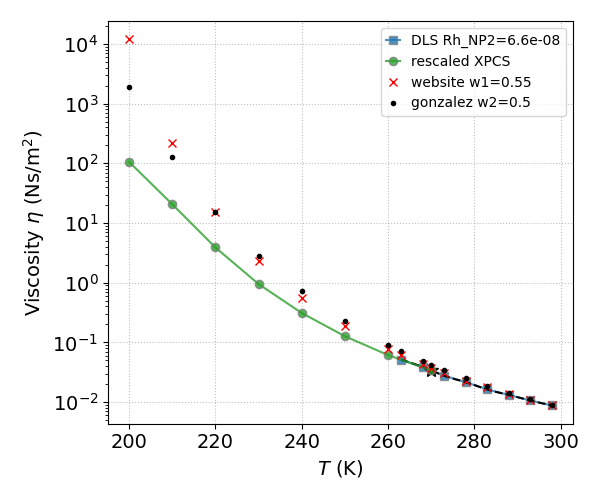

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

# -- From NP
# NP XPS data from viscosity_NP.npz 
# ax.plot(f['T_np'][1:], f['eta_np'][1:], label='XPCS', c='C2', mec='gray', alpha=0.8, marker='x')

# DLS NP100nm 23m/ol%
Rh_NP2 = 66e-9 # like in sharon's PCCP
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP2 * f_dls_D*1e-12) # change Rh
ax.plot(f_dls_T, eta_dls, label=f'DLS {Rh_NP2=}', c='C0', mec='gray', alpha=0.8, marker='s')#, mfc='none')

# interpolate
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
ax.plot(new_x, lin_interp(new_x), 'k--')

mask = (new_x == f['T_np'][-1])
plt.plot(new_x[mask], lin_interp(new_x)[mask], ls='', marker='*', c='k', ms=10)
print(new_x[mask], lin_interp(new_x)[mask])

# rescale
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]
ax.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='rescaled XPCS', c='C2', mec='gray', alpha=0.8, marker='o')

all_T = np.array([200., 210., 220., 230., 240., 250., 260., 263., 268., 270., 273., 278., 283., 288., 293., 298.])
# From tabulated values
w1 = 0.55
eta_anita = viscosity_glywater(T=all_T-273, weight_percent=0.6)
plt.plot(all_T, eta_anita, ls='', marker='x', c='r', label=f'website {w1=}')

# Gonzalez et al 2011
w2 = 0.5
eta_new = viscosity_predic(T=all_T, w=w2)
plt.plot(all_T, eta_new, ls='', marker='.', c='k', label=f'gonzalez {w2=}')


# w2 = 0.6
# eta_new2 = viscosity_predic(T=all_T, w=w2)# eta0=np.exp(-0.923)*1e-3, alpha = 3.863, Tg=165.1)
# plt.plot(all_T, eta_new2, ls='', marker='s', c='k', label=f'gonzalez {w2=}')


# plt.plot(all_T, viscosity_predic_fit(all_T, *popt), ls='-', c='r', label=f'fit')


# -- plot settings
ax.set_ylabel("Viscosity $\eta$ (Ns/m$^2$)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
# ax.set_xlim(240,300)
# ax.set_ylim(0.01,0.1)
plt.tight_layout()

# Plot

In [17]:
SE = Kbb*f_23['T'] / (6*np.pi*Rh*f_23['eta'])
ax.plot(scale/f_23['T'], SE*1e12, marker='o', c='C2', alpha=0.8,  ls='', mec='gray', label='SE 23mol%', zorder=2)

NameError: name 'Kbb' is not defined

In [ ]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()

scale = 1e3
cols = plt.cm.copper_r(np.linspace(0,1,3))

Kbb = 1.3806e-23 # J/K
Rh = 7.3e-9
Na = 6.02214076e23 
new_T = np.linspace(210,300,100)

# xpcs c1 in 19 mol%
# ax.errorbar(scale/Dc1['T'], Dc1['D'], Dc1['dD'], marker='o', c='C1',  mec='gray', label='100 19mol% XPCS')
SE = Kbb*f_23['T'] / (6*np.pi*Rh*f_23['eta'])
ax.plot(scale/f_23['T'], SE*1e12, marker='o', c='C2', alpha=0.8,  ls='', mec='gray', label='SE 23mol%', zorder=2)

# -- VFT fit NP
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, f_23['T'],  SE*1e12, sigma=SE*1e12*0.01, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 200)]) # VFT(x, a, D, T0)
print(f'NP VFT: ', popt_NP, perr_NP)
print("B: ", -popt_NP[1]*popt_NP[2])

# -- proteins
rescale = SE[5]*1e12 / Dc1['D'][0]
ax.errorbar(scale/Dc1['T'], Dc1['D'] * rescale, Dc1['dD'] * rescale,marker='o', c='C1', ls='',  mec='gray',label='100 23mol% XPCS', zorder=1)


# -- VFT fit NP + protein XPCS
limm = 10
fit_x = np.concatenate([f_23['T'][-11:], Dc1['T']])
fit_y = np.concatenate([SE[-11:]*1e12,  Dc1['D']])
fit_dy = np.concatenate([SE[-11:]*1e12*0.01, Dc1['dD']])
popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty,0,200)]) # VFT(x, a, D, T0)
popt_p2,xc_p2,curve_p2,perr_p2 = fit(MCT, fit_x, fit_y, sigma=fit_dy, p0=[1e-4, 210, 1.],) # MCT(T, A, Ts, gamma)
print("MCT: ", popt_p2)

ax.plot(scale/new_T, VFT(new_T, *popt_p), ls=':', c='k', label='VFT ferritin', zorder=10)
ax.plot(scale/new_T, VFT(new_T, *popt_NP), ls='--', c='k', label='VFT NP', zorder=20, lw=1)

# ax.plot(scale/new_T, MCT(new_T, *popt_p2), ls='--', c='r', label='MCT ferritin', zorder=10)

print("prot: ", popt_p, perr_p)
print("B: ", -popt_p[1]*popt_p[2])

# -- plot setting
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
ax.legend(fontsize=8, handlelength=1, loc='lower left', title='c (mg/ml)', title_fontsize=9)
ax.set_yscale('log')
ax.set_ylim(1e-4,1e1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)


VFT NP:  [ 6.05476077e+04 -1.15845307e+01  1.21858736e+02] [2.73081881e+04 1.29417537e+00 4.31027487e+00]

VFT ferritin:  [ 6.97217578e+05 -2.63567715e+01  8.45477805e+01] [6.91429694e+05 7.59478561e+00 1.19069334e+01]
VFT(x, a, D, T0)
[2.6921025  1.49253767 0.9956393  0.99651939 0.94641728]


(198.0, 260.0)

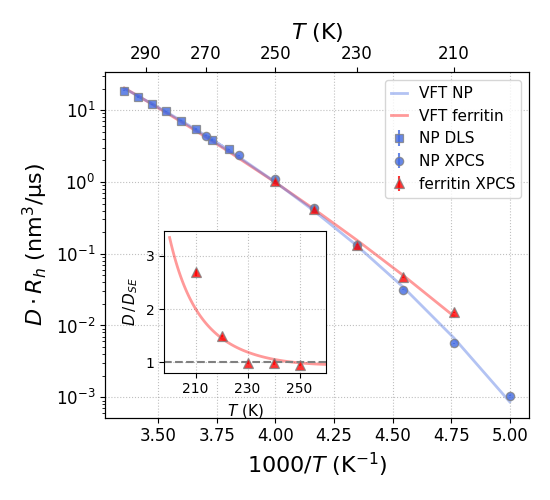

In [34]:
fig, a1 = plt.subplots(1,1, figsize=(5.5,5), tight_layout=True)
# inset
# a1 = a3.inset_axes([.53, .15, .45, .45])

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2
# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

###### PANEL A
# -- dls
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.9, marker='s', zorder=2)
popt1,xc,curve1,perr1 = fit(arrhenius, f_dls_T,  f_dls_D*1e-12 * Rh_NP * correct_unit, p0=[1e7, -4e3])
Ea1, dEa1 = popt1[1] * kb / 1e3 * Na, perr1[1] * kb / 1e3 * Na
dls_ex_T = np.arange(200, 301, 10)

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a1.errorbar(scale/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, SE[1: ] * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.9, zorder=3)

# -- ferritin
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.9,  alpha=0.8, mec='gray', label='ferritin XPCS', zorder=4)


# -- VFT NP
fit_x = np.concatenate([f['T_np'][1:], f_dls_T])
fit_y = np.concatenate([ SE[1: ] * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP, xc_NP, curve_NP, perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 250)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.4, lw=2, label='VFT NP', zorder=1)


# -- VFT ferritin XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
# fit_x = np.concatenate([Dc1['T'][::-1]])
# fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_y * 0.02, p0=[100, -1., 110], bounds=[(0,-np.infty,0), (np.infty,0,250)]) # VFT(x, a, D, T0) 

print("\nVFT NP: ", popt_NP, perr_NP)
print("\nVFT ferritin: ", popt_p, perr_p)
print("VFT(x, a, D, T0)")
a1.plot(scale/fit_x, VFT(fit_x, *popt_p), ls='-', c='red', lw=2, alpha=0.4, label='VFT ferritin', zorder=0)


# inset
a2 = a1.inset_axes([.14, .13, .38, .41])

T_NP_ratio = f['T_np'][2:7]
D_NP_ratio = SE[2:7] * Rh_NP * correct_unit # f['T_np'][2:7]

ratio = Dc1['D'][::-1]*1e-12 * Rh * correct_unit / D_NP_ratio
dratio = Dc1['dD'][::-1]*1e-12 * Rh * correct_unit / D_NP_ratio
print(ratio)

a2.errorbar(T_NP_ratio, ratio, dratio, marker='^', ms=7, c='r', ls='', mew=.9,  alpha=0.8, mec='gray',)
a2.plot(np.linspace(200,260,100), VFT(np.linspace(200,260,100), *popt_p) / VFT(np.linspace(200,260,100), *popt_NP), c='r', alpha=0.4, ls='-', lw=2 )
a2.axhline(y=1, c='gray', ls='--')


# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.legend(handlelength=1, fontsize=11, loc='upper right')#bbox_to_anchor=[1.5,1])
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

a2.set_ylabel("$D\,/\,D_{SE}$", fontsize=11)
a2.set_xlabel("$T$ (K)", fontsize=11)
a2.tick_params(axis='both', which='major', labelsize=10)
a2.set_yticks(np.arange(1,3.1,1))
a2.set_xticks(np.arange(210, 251,20))
# a2.set_ylim(0,12)
a2.set_xlim(198, 260)

# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=300)

# with fractional


VFT NP:  [ 6.05476077e+04 -1.15845307e+01  1.21858736e+02] [2.73081881e+04 1.29417537e+00 4.31027487e+00]

VFT ferritin:  [ 6.97217578e+05 -2.63567715e+01  8.45477805e+01] [6.91429694e+05 7.59478561e+00 1.19069334e+01]
VFT(x, a, D, T0)
Exponent (NP): 1.02 pm 0.01
Exponent (protein): -0.807 pm 0.04


Text(0.7, 0.1, '$\\xi$=1.02')

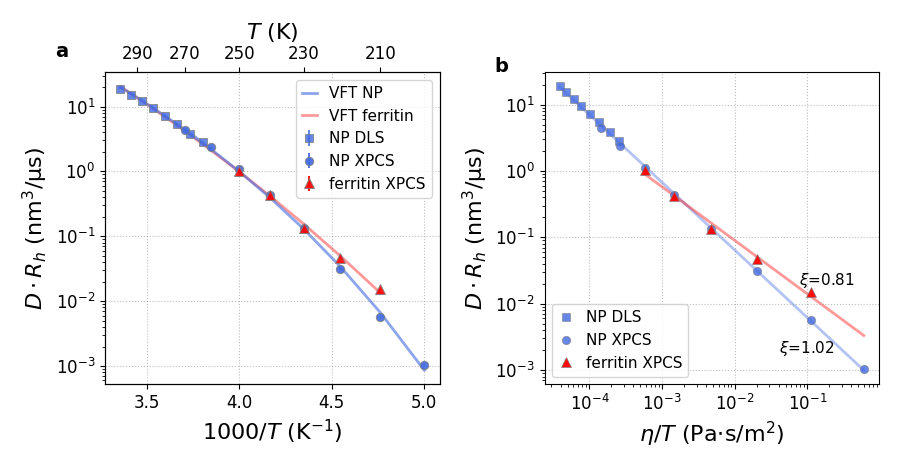

In [22]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(9,4.7), tight_layout=True)
# inset
# a1 = a3.inset_axes([.53, .15, .45, .45])


correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2
# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

###### PANEL A
# -- dls
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.7, marker='s', zorder=2)
popt1,xc,curve1,perr1 = fit(arrhenius, f_dls_T,  f_dls_D*1e-12 * Rh_NP * correct_unit, p0=[1e7, -4e3])
Ea1, dEa1 = popt1[1] * kb / 1e3 * Na, perr1[1] * kb / 1e3 * Na
dls_ex_T = np.arange(200, 301, 10)

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a1.errorbar(scale/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, SE[1: ] * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.9, marker='o', mew=.7, zorder=3)

# -- ferritin
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.7,  alpha=0.9, mec='gray', label='ferritin XPCS', zorder=4)


# -- VFT NP
fit_x = np.concatenate([f['T_np'][1:], f_dls_T])
fit_y = np.concatenate([ SE[1: ] * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP, xc_NP, curve_NP, perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 250)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.6, lw=2, label='VFT NP', zorder=1)


# -- VFT ferritin XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
# fit_x = np.concatenate([Dc1['T'][::-1]])
# fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_y * 0.02, p0=[100, -1., 110], bounds=[(0,-np.infty,0), (np.infty,0,250)]) # VFT(x, a, D, T0) 

print("\nVFT NP: ", popt_NP, perr_NP)
print("\nVFT ferritin: ", popt_p, perr_p)
print("VFT(x, a, D, T0)")
a1.plot(scale/fit_x, VFT(fit_x, *popt_p), ls='-', c='red', lw=2, alpha=0.4, label='VFT ferritin', zorder=0)




###### PANEL B
# -- DLS NP100nm 23m/ol%
x_NP = np.concatenate([f_dls_T/eta_dls, f['T_np'][1:]/f['eta_np'][1:]])
x_NP2 = np.concatenate([f_dls_T, f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D*1e-12 * Rh_NP, SE[1:] * Rh_NP])

a2.plot(eta_dls/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a2.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)

# -- fit NP
popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])
# a2.plot(1/np.exp(xc), np.exp(curve) * correct_unit , '-k', zorder=1, lw=1)
a2.plot(1/np.exp(xc), np.exp(curve) * correct_unit , ls='-', c='royalblue', lw=2, alpha=0.4, zorder=1)
print(f"Exponent (NP): {popt[0]:.2f} pm {perr[0]:.2f}")

# -- xpcs c1 in 19 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
a2.plot(etas/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit,  marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin XPCS', zorder=4)

# protein fit
x_pr = np.concatenate([eta_dls/f_dls_T, etas/Dc1['T']])
y_pr = np.concatenate([f_dls_D*1e-12 * Rh_NP, Dc1['D']*1e-12 * Rh])
popt2,xc2,curve2,perr2 = fit(linear_q, np.log(etas/Dc1['T']), np.log(Dc1['D']*1e-12 * Rh), sigma=np.log(Dc1['D']*1e-12)*0.01, p0=[1.,1.])
print(f"Exponent (protein): { popt2[0]:.3f} pm {perr2[0]:.2f}")
# -- fit of ferritin, longer x axis
nnewx = np.linspace(np.min(np.log(etas/Dc1['T'])), np.log(f['eta_np'][1]/f['T_np'][1]), 100)
a2.plot(np.exp(nnewx), np.exp(linear_q(nnewx, *popt2)) * correct_unit, ls='-', c='r', alpha=0.4, lw=2, zorder=1)


# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.legend(handlelength=1, fontsize=11)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)


a2.set_xlabel("$\eta/T$ (Pa$\cdot$s/m$^{2}$)", fontsize=16)
a2.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a2.legend(handlelength=1, loc='lower left', fontsize=11)
a2.set_yscale('log')
a2.set_xscale('log')
a2.tick_params(axis='both', which='major', labelsize=12)

a1.text(-0.15, 1.05, 'a', fontweight='bold', transform=a1.transAxes)
a2.text(-0.15, 1, 'b', fontweight='bold', transform=a2.transAxes)

a2.text(0.76, 0.32, r'$\xi$=0.81', transform=a2.transAxes, fontsize=11)
a2.text(0.7, 0.1, r'$\xi$=1.02', transform=a2.transAxes, fontsize=11)
# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=300)

# for thesis


VFT NP:  [ 6.05476077e+04 -1.15845307e+01  1.21858736e+02] [2.73081881e+04 1.29417537e+00 4.31027487e+00]

VFT ferritin:  [ 6.97219829e+05 -2.63567953e+01  8.45477439e+01] [6.91431843e+05 7.59479193e+00 1.19069316e+01]
VFT(x, a, D, T0)
[2.6921025  1.49253767 0.9956393  0.99651939 0.94641728]


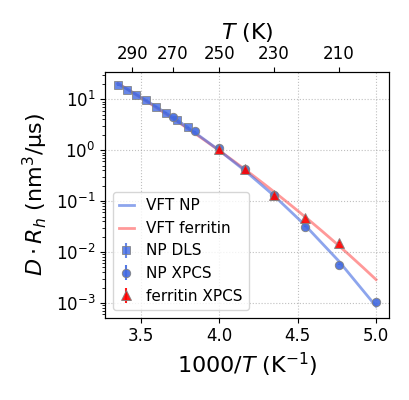

In [23]:
fig, a1 = plt.subplots(1,1, figsize=(4.1,4), tight_layout=True)
# fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
# inset
# a1 = a3.inset_axes([.53, .15, .45, .45])


correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2
# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

###### PANEL A
# -- dls
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.7, marker='s', zorder=2)
popt1,xc,curve1,perr1 = fit(arrhenius, f_dls_T,  f_dls_D*1e-12 * Rh_NP * correct_unit, p0=[1e7, -4e3])
Ea1, dEa1 = popt1[1] * kb / 1e3 * Na, perr1[1] * kb / 1e3 * Na
dls_ex_T = np.arange(200, 301, 10)

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a1.errorbar(scale/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, SE[1: ] * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.9, marker='o', mew=.7, zorder=3)

# -- ferritin
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.7,  alpha=0.9, mec='gray', label='ferritin XPCS', zorder=4)


# -- VFT NP
fit_x = np.concatenate([f['T_np'][1:], f_dls_T])
fit_y = np.concatenate([ SE[1: ] * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP, xc_NP, curve_NP, perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 250)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.6, lw=2, label='VFT NP', zorder=1)


# -- VFT ferritin XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
# fit_x = np.concatenate([Dc1['T'][::-1]])
# fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit])
Tl = np.linspace(200, np.max(f_dls_T), 1000)
popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_y * 0.02, p0=[1e5, -26, 86], bounds=[(0,-np.infty,50), (np.infty,0,150)]) # VFT(x, a, D, T0) 

print("\nVFT NP: ", popt_NP, perr_NP)
print("\nVFT ferritin: ", popt_p, perr_p)
print("VFT(x, a, D, T0)")
a1.plot(scale/Tl, VFT(Tl, *popt_p), ls='-', c='red', lw=2, alpha=0.4, label='VFT ferritin', zorder=0)


# a2 = a1.inset_axes([.14, .13, .38, .41])
T_NP_ratio = f['T_np'][2:7]
D_NP_ratio = SE[2:7] * Rh_NP * correct_unit # f['T_np'][2:7]

ratio = Dc1['D'][::-1]*1e-12 * Rh * correct_unit / D_NP_ratio
dratio = Dc1['dD'][::-1]*1e-12 * Rh * correct_unit / D_NP_ratio
print(ratio)

a2.errorbar(T_NP_ratio, ratio, dratio, marker='^', ms=7, c='r', ls='', mew=.7,  alpha=0.9, mec='gray',)
a2.plot(np.linspace(200,260,100), VFT(np.linspace(200,260,100), *popt_p) / VFT(np.linspace(200,260,100), *popt_NP), c='r', alpha=0.9, ls='-', )
# print(np.linsoac(200,260,100))
a2.axhline(y=1, c='gray', ls='--')



# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.legend(handlelength=1, fontsize=11)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

# a2.set_ylabel("$D\,/\,D_{SE}$", fontsize=16)
# a2.set_xlabel("$T$ (K)", fontsize=16)
# a2.tick_params(axis='both', which='major', labelsize=12)
# a2.set_xlim(190, 300)

# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=300)